In [3]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [4]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
if IN_COLAB:
    # Put here the full path to the folder having the project code and Dataset
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/Rodri De Papi/Proyecto Final/Herramienta CAD de segmentacion automatica del GBM/Tiago"
    %cd $ROOT_DIR

/content/drive/.shortcut-targets-by-id/1qQQt5gfSRzq8Dv3Xk-rIgh1hh2aEZxBs/Rodri De Papi/Proyecto Final/Herramienta CAD de segmentacion automatica del GBM/Tiago


In [6]:
if IN_COLAB:
    # This will make sure we have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214949 sha256=3b945c5ddc52e817a13540b7a96

In [7]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import torch

from types import SimpleNamespace
import wandb
import logging

logging.basicConfig(level=logging.INFO)
logging.info(print_config())


MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recomme

### Setup data directory
You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [8]:
root_dir = "/content/drive/MyDrive/Rodri De Papi/Proyecto Final/Herramienta CAD de segmentacion automatica del GBM/Tiago/Data"

In [9]:
# Set deterministic training for reproducibility
set_determinism(seed=0)

### Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [10]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            #result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            result.append(d[key] == 2)
            # merge labels 1, 2 and 3 to construct WT
            #result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            result.append(d[key] == 1)
            # label 2 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d

### Setup transforms for training and validation

In [11]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


### Quickly load data with DecathlonDataset
Here we use DecathlonDataset to automatically download and extract the dataset. It inherits MONAI CacheDataset, if you want to use less memory, you can set cache_num=N to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size

In [12]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True, # descargr una vez, luego poner False
    cache_rate=0.0,
    num_workers=2,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False, # descargr una vez, luego poner False
    cache_rate=0.0,
    num_workers=2,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

image shape: torch.Size([4, 240, 240, 155])


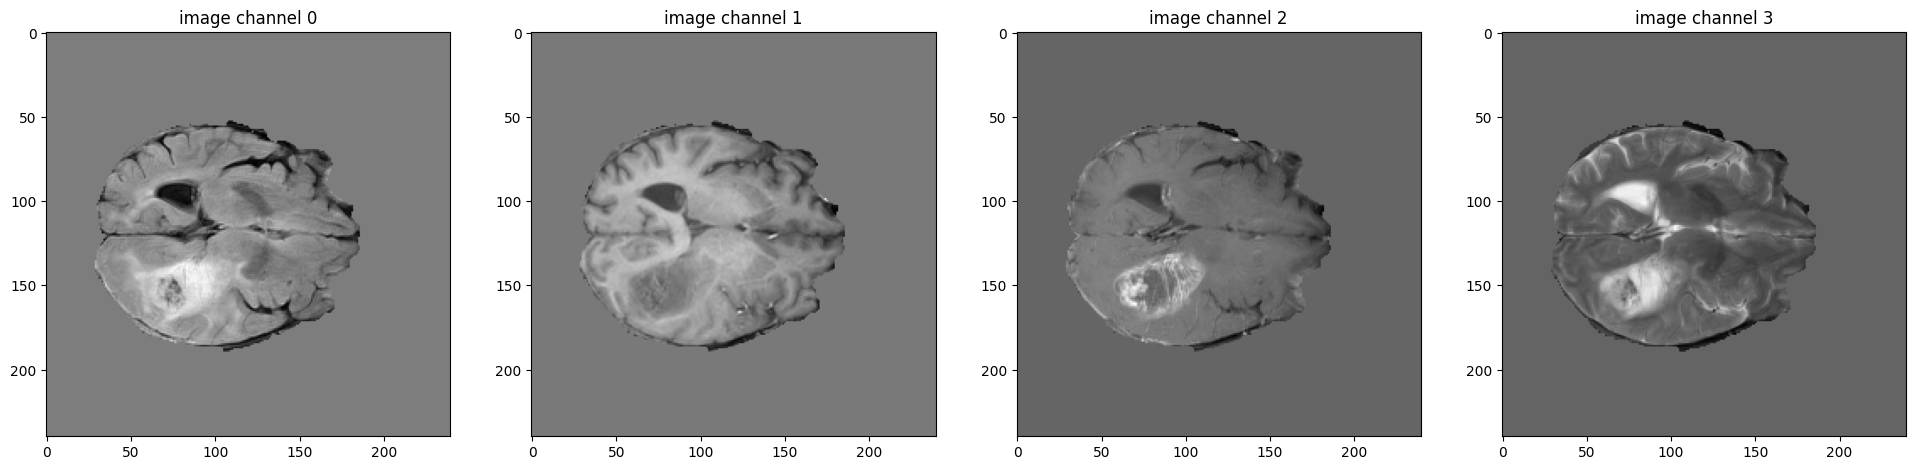

label shape: torch.Size([3, 240, 240, 155])


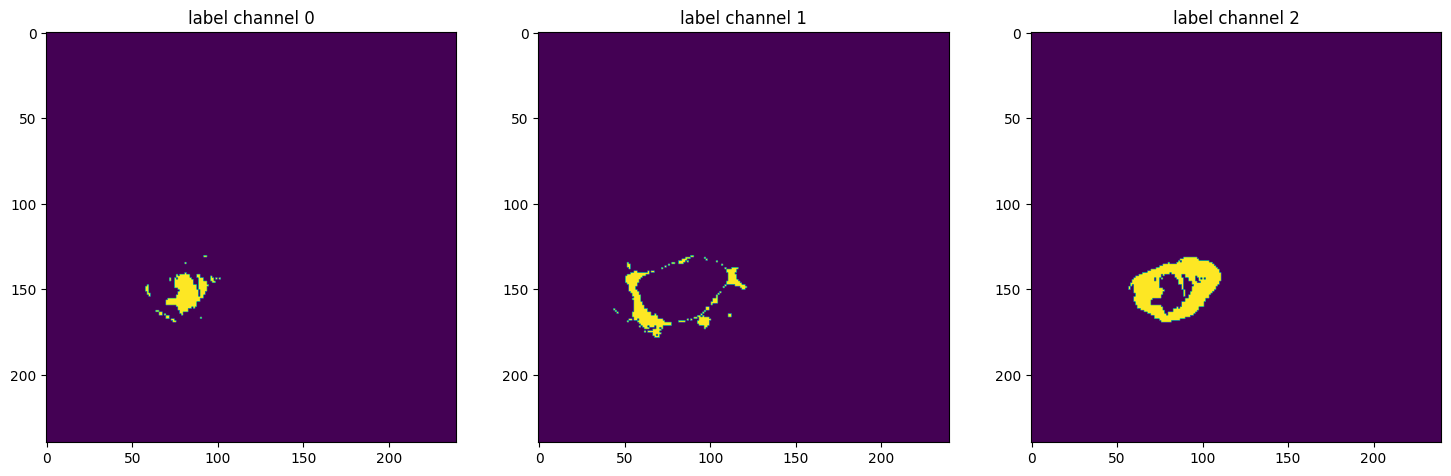

In [13]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[6]
sl=70
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer

In [14]:
# Select device gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

!nvidia-smi

Device: cuda
Sun Mar  3 21:36:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

# Inicializar wandb

In [15]:
#################################
# HIPER PARAMETER CONFIGURATION #
#################################
config_train = SimpleNamespace(
        # network hyperparameters
        init_filters=16,
        dropout_prob=0.2,
        # training hyperparameters
        max_epochs=2,
        lrate=1e-4,
        weight_decay=1e-5,
        batch_size=1,
        # Post
        threshold=0.5,
        # Train type
        use_scaler=True,
        use_autocast=True,
    )

In [16]:
os.environ["WANDB_API_KEY"] = '01c54ce2751fbe1574c7d3f0004d623f0f51de26'

In [17]:
#############################
### Inicializar WandB
#############################
# Cargar la clave API desde una variable de entorno
logging.info("Logging in WandB")
api_key = os.environ.get("WANDB_API_KEY")

# Iniciar sesión en W&B
wandb.login(key=api_key)

# # create a wandb run
run = wandb.init(project="SegResNet-1", job_type="train", config=config_train)


wandb: Currently logged in as: psalmon (brain-ar). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/drive/.shortcut-targets-by-id/1qQQt5gfSRzq8Dv3Xk-rIgh1hh2aEZxBs/Rodri De Papi/Proyecto Final/Herramienta CAD de segmentacion automatica del GBM/Tiago/wandb/run-20240303_213620-1dxhp7xc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wild-river-3
wandb: ⭐️ View project at https://wandb.ai/brain-ar/SegResNet-1
wandb: 🚀 View run at https://wandb.ai/brain-ar/SegResNet-1/runs/1dxhp7xc


In [18]:
max_epochs = config_train.max_epochs
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=config_train.init_filters,
    in_channels=4,
    out_channels=3,
    dropout_prob=config_train.dropout_prob,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), config_train.lrate, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input, model, VAL_AMP=config_train.use_autocast):
    def _compute(input):
        return sliding_window_inference(
                inputs=input,
                roi_size=(240, 240, 160),
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
            )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Execute a typical PyTorch training process

In [19]:
best_metric = 1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
# last_epoch = 24

total_start = time.time()
for epoch in range(max_epochs):
        torch.cuda.empty_cache()
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()

            if config_train.use_scaler:
                # with autocast
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # without autocast
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()

            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )
            # wandb log: loss, lr and epoch
            wandb.log(
                {
                    "loss": loss.item(),
                    "lr": optimizer.param_groups[0]["lr"],
                    "epoch": epoch,
                }
            )
            torch.cuda.empty_cache()
        lr_scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # wandb log: epoch_loss
        wandb.log(
            {
                "Epoch_Average_Loss": epoch_loss,
            }
        )

        if epoch_loss < best_metric:
            best_metric = epoch_loss
            best_metric_epoch = epoch + 1

            best_model_file = os.path.join(root_dir, "best_metric_model.pth")

            torch.save(
                model.state_dict(),
                best_model_file,
            )
            torch.cuda.empty_cache()
            print("saved new best metric model")

        print(
            f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}"
        )
# wandb save the best model
artifact_name = f"{wandb.run.id}_best_model"
at = wandb.Artifact(artifact_name, type="model")
at.add_file(best_model_file)
wandb.log_artifact(at, aliases=[f"epoch_{epoch}"])

total_time = time.time() - total_start
logging.info(f"Total time: {total_time}")

# finish W&B run
wandb.finish()

----------
epoch 1/2
1/388, train_loss: 0.9801, step time: 10.3572
2/388, train_loss: 0.9840, step time: 1.0128
3/388, train_loss: 0.9919, step time: 1.0681
4/388, train_loss: 0.9649, step time: 1.1171
5/388, train_loss: 0.9911, step time: 0.9851
6/388, train_loss: 0.9599, step time: 0.9871
7/388, train_loss: 0.9773, step time: 1.2496
8/388, train_loss: 0.9514, step time: 1.1194
9/388, train_loss: 0.9903, step time: 0.9985
10/388, train_loss: 0.9577, step time: 1.0657
11/388, train_loss: 0.9346, step time: 0.9950
12/388, train_loss: 0.9364, step time: 1.0990
13/388, train_loss: 0.9699, step time: 1.1397
14/388, train_loss: 0.9207, step time: 1.0906
15/388, train_loss: 0.9542, step time: 1.0833
16/388, train_loss: 0.9660, step time: 1.0851
17/388, train_loss: 0.9747, step time: 1.1260
18/388, train_loss: 0.9568, step time: 1.0761
19/388, train_loss: 0.9693, step time: 1.0106
20/388, train_loss: 0.9155, step time: 1.1061
21/388, train_loss: 0.9653, step time: 1.2056
22/388, train_loss: 0

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: Epoch_Average_Loss █▁
wandb:              epoch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
wandb:               loss ▆▆▅▆██▅▅█▆▄█▄▅▇▅▆▅▃▅▆▆▇▄▅▄█▅▇▆▅▃▁▄▇▆▆▅▇▅
wandb:                 lr ████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: Epoch_Average_Loss 0.92331
wandb:              epoch 1
wandb:               loss 0.92577
wandb:                 lr 5e-05
wandb: 
wandb: 🚀 View run wild-river-3 at: https://wandb.ai/brain-ar/SegResNet-1/runs/1dxhp7xc
wandb: Synced 5 W&B file(s), 0 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240303_213620-1dxhp7xc/logs


In [20]:
wandb.finish()

In [21]:
#print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}.")

train completed, best_metric: 0.9233 at epoch: 2.


### Plot loss metric

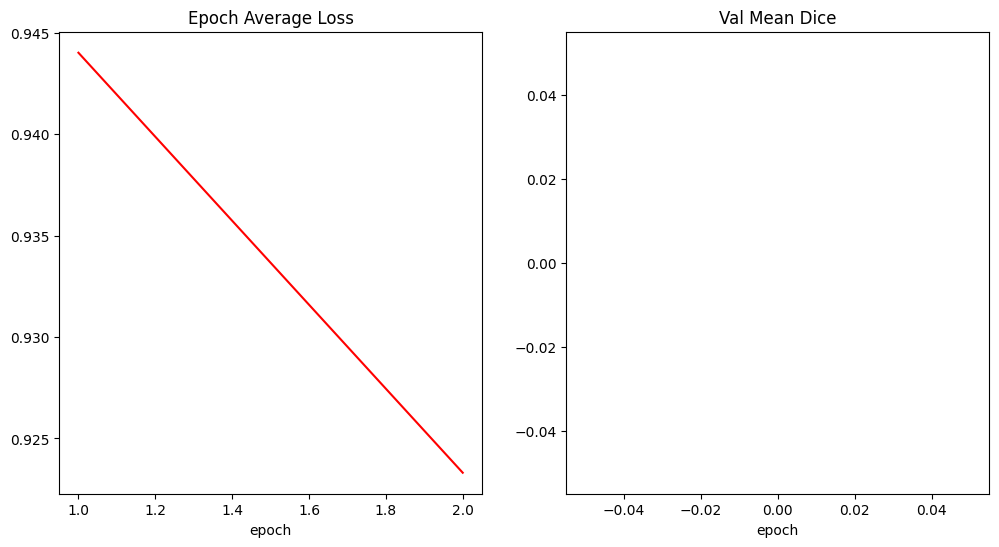

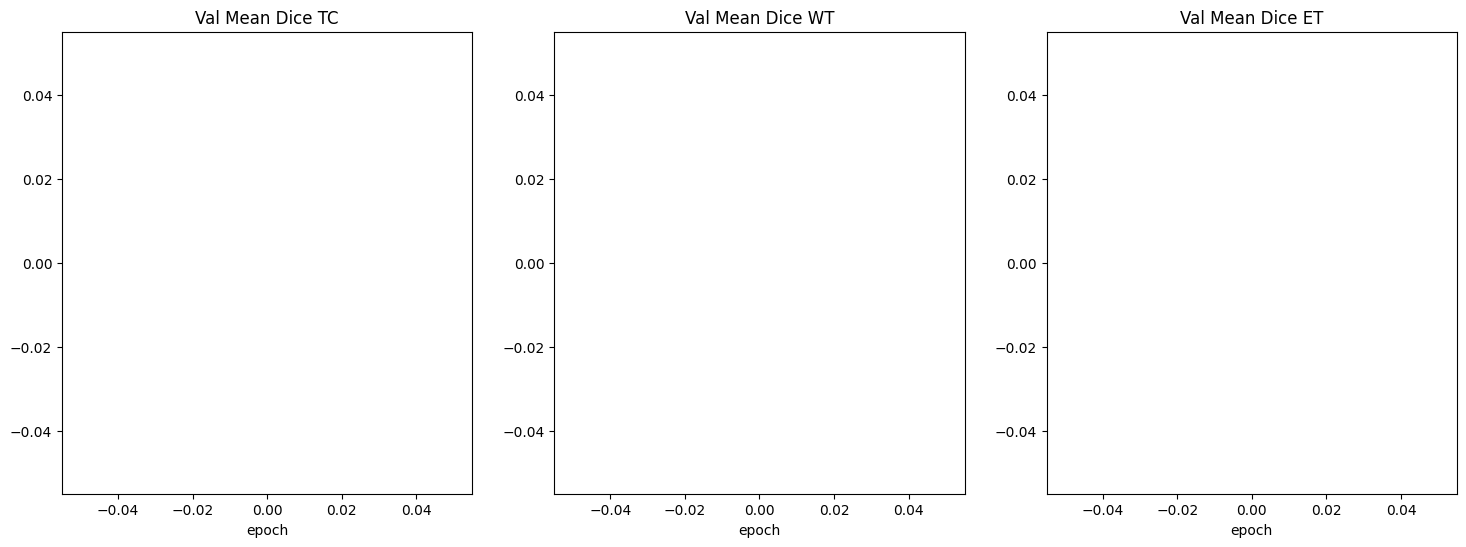

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

### Check best model output with the input image and label

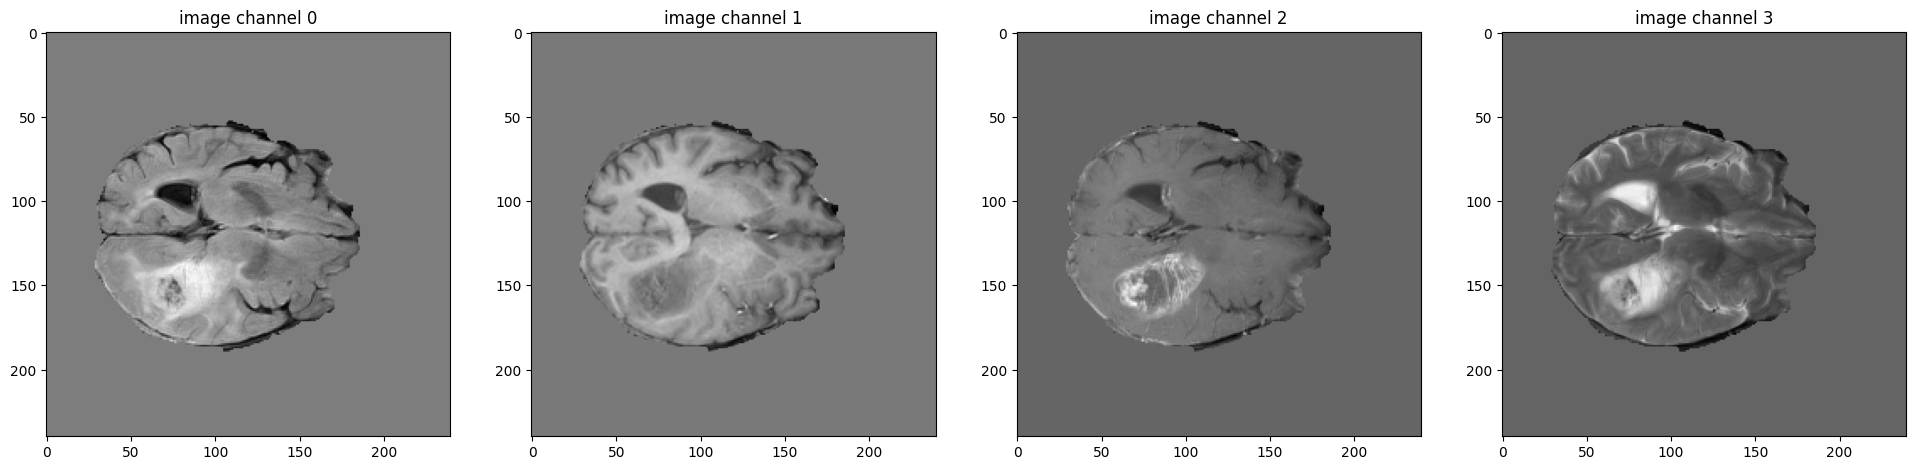

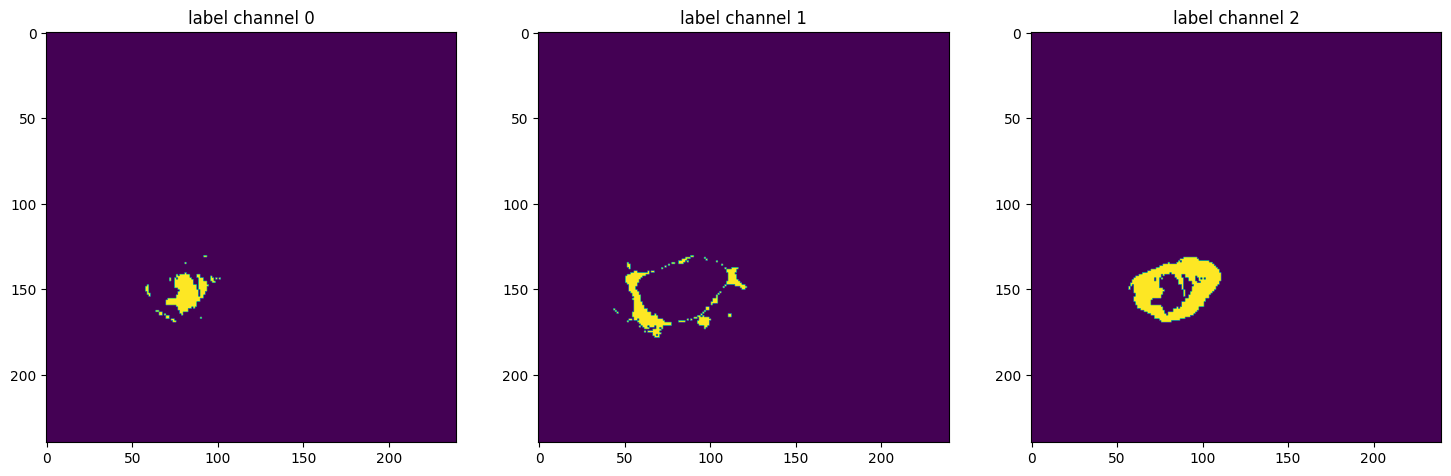

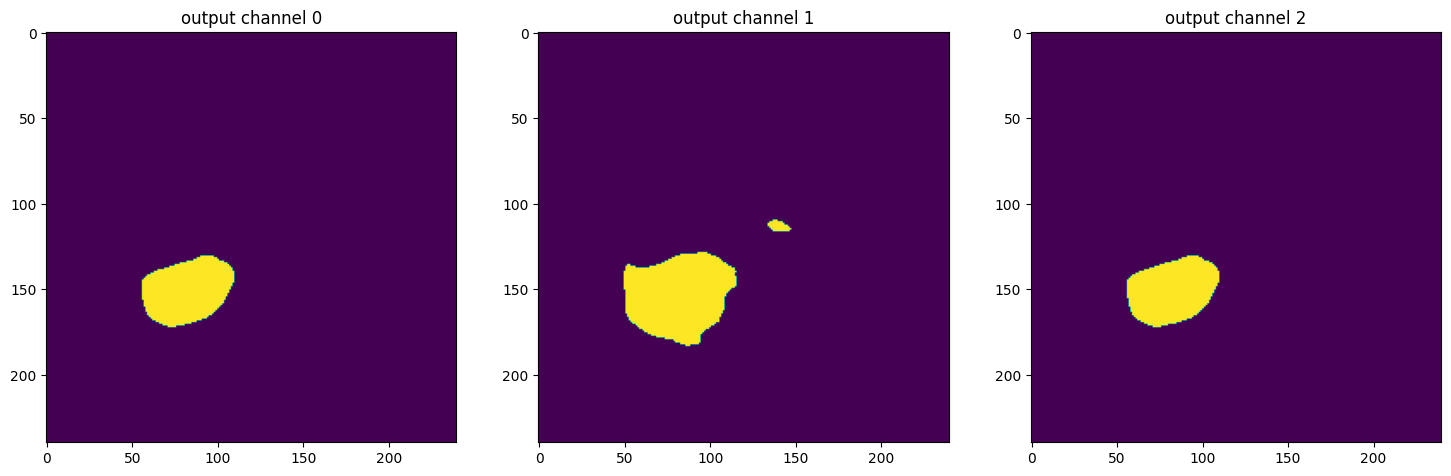

In [23]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), map_location=torch.device('cpu')))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input,model)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

### Evaluation on original image spacings

In [24]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=2)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [25]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"),map_location=torch.device('cpu')))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs,model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.3401181995868683
metric_tc: 0.2495
metric_wt: 0.4645
metric_et: 0.3095
